In [36]:
!pip install sweetviz category_encoders

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sweetviz
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
from sklearn import model_selection

In [16]:
data = pd.read_csv('https://raw.githubusercontent.com/Hg03/Loan-Approval-Machine-Learning-Project/main/data/loan_data.csv')
data.head()

,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status,loan_status_encoded
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved,1
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected,0
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected,0
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected,0
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected,0


In [17]:
train, test = model_selection.train_test_split(data.drop(['loan_id','loan_status'],axis=1), test_size=0.3,shuffle=42,stratify=data.loan_status_encoded)

## EDA

In [18]:
report = sweetviz.analyze([train,"Train"],target_feat='loan_status_encoded')

                                             |          | [  0%]   00:00 -> (? left)

In [19]:
report.show_html("Report.html")

Report Report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [20]:
x_train,x_test,y_train,y_test = train.drop(['loan_status_encoded'],axis=1),test.drop(['loan_status_encoded'],axis=1),train.loan_status_encoded,test.loan_status_encoded

In [21]:
x_train.head()

,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value
2947,1,Not Graduate,Yes,3400000,9700000,20,830,3500000,6400000,10300000,4800000
3634,0,Graduate,No,1500000,4300000,12,801,4400000,2200000,3300000,1100000
22,4,Graduate,Yes,6500000,25700000,18,311,13100000,1700000,19500000,8500000
1417,4,Not Graduate,No,400000,1000000,10,447,0,300000,900000,300000
3116,5,Graduate,Yes,3400000,9800000,8,559,3500000,2900000,8300000,2200000


In [23]:
x_train.isnull().sum()

no_of_dependents            0
education                   0
self_employed               0
income_annum                0
loan_amount                 0
loan_term                   0
cibil_score                 0
residential_assets_value    0
commercial_assets_value     0
luxury_assets_value         0
bank_asset_value            0
dtype: int64

In [28]:
numerical_features = x_train.select_dtypes(include='number').columns
categorical_features = x_train.select_dtypes(include='object').columns

In [30]:
ordinal_features = categorical_features

<Axes: >

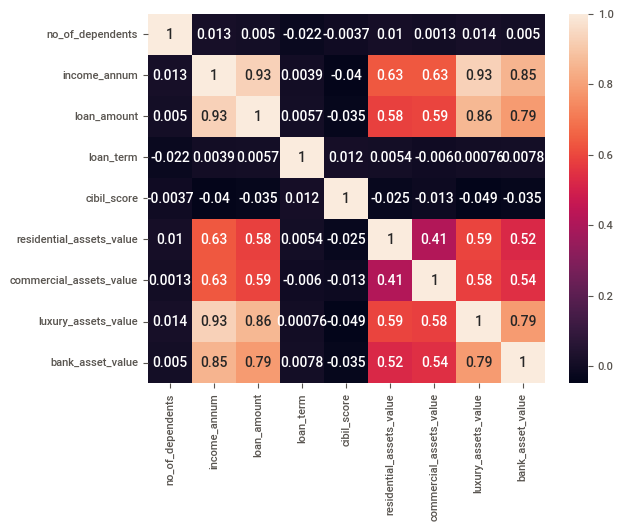

In [34]:
import seaborn as sns
sns.heatmap(x_train[numerical_features].corr(),annot=True)

In [47]:
from sklearn import impute, preprocessing, metrics, compose, pipeline, tree, ensemble, linear_model
from category_encoders import BinaryEncoder

In [39]:
num_imputer = impute.SimpleImputer(strategy = 'mean')
cat_imputer = impute.SimpleImputer(strategy = 'most_frequent')
cat_encoder = BinaryEncoder()

In [44]:
p1 = compose.make_column_transformer((num_imputer,numerical_features),(cat_imputer,['education','self_employed']),remainder='passthrough')
p2 = compose.make_column_transformer((cat_encoder,[-1,-2]),remainder='passthrough')
preprocessing_pipeline = pipeline.make_pipeline(p1,p2)
preprocessing_pipeline.fit(x_train)

Pipeline(steps=[('columntransformer-1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('simpleimputer-1',
                                                  SimpleImputer(),
                                                  Index(['no_of_dependents', 'income_annum', 'loan_amount', 'loan_term',
       'cibil_score', 'residential_assets_value', 'commercial_assets_value',
       'luxury_assets_value', 'bank_asset_value'],
      dtype='object')),
                                                 ('simpleimputer-2',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['education',
                                                   'self_employed'])])),
                ('columntransformer-2',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('binaryencoder',
                                                  BinaryEncoder(),
                                                  [-1, -2])]))])

In [50]:
rf = ensemble.RandomForestClassifier()
rf_pipeline = pipeline.make_pipeline(preprocessing_pipeline,rf)
rf_pipeline.fit(x_train,y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer-1',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('simpleimputer-1',
                                                                   SimpleImputer(),
                                                                   Index(['no_of_dependents', 'income_annum', 'loan_amount', 'loan_term',
       'cibil_score', 'residential_assets_value', 'commercial_assets_value',
       'luxury_assets_value', 'bank_asset_value'],
      dtype='object')),
                                                                  ('simpleimputer-2',
                                                                   SimpleImputer(strategy='most_frequent'),
                                                                   ['education',
                                                                    'self_employed'])])),
                                 ('columntransformer-2',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('binaryencoder',
                                                                   BinaryEncoder(),
                                                                   [-1,
                                                                    -2])]))])),
                ('randomforestclassifier', RandomForestClassifier())])

In [51]:
y_pred = rf_pipeline.predict(x_test)

In [52]:
score = metrics.cohen_kappa_score(y_test,y_pred)

In [53]:
score

0.9617329345097158

In [54]:
confusion_matrix = metrics.confusion_matrix(y_test,y_pred)

In [55]:
confusion_matrix

array([[470,  14],
       [  9, 788]])

In [56]:
import joblib
joblib.dump(rf_pipeline,'model.sav')

['model.sav']

In [57]:
model = joblib.load('model.sav')

In [59]:
sample = data.head(1)

,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status,loan_status_encoded
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved,1


In [61]:
model.predict(sample)

array([1])